# YOLOv3

You Only Look Once (YOLO) is an state-of-art, real time object detection algorithm.

YOLO uses *Darknet*, an open source, deep neural network framework written by the creators of YOLO. The version of *Darknet* used in this notebook has been modified to work in PyTorch 0.4 and has been simplified because we won't be doing any training. Instead, we will be using a set of pre-trained weights that were trained on the Common Objects in Context (COCO) database. 

In [11]:
%matplotlib inline 

import cv2
import matplotlib.pyplot as plt 
import numpy as np
import time 
import torch
import matplotlib.patches as patches

from darknet import Darknet
from utils import load_class_names, print_objects, plot_boxes

## Setting up the neural network

- `yolov3.cfg` contains the network architecture used by YOLOv3 
- `yolov3.weights` contains the pre-trained weights 
- `coco.names` contains the list of 80 object classes that the weights were trained to detect

In [2]:
cfg_file = './models/YOLOv3/yolov3.cfg'
weight_file = './models/YOLOv3/yolov3.weights'
names_file = './models/YOLOv3/coco.names'

model = Darknet(cfg_file)
model.load_weights(weight_file)
class_names = load_class_names(names_file)

model.print_network()


layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 

## Non-Maximal Suppression

YOLO uses **Non-Maximal Suppression (NMS)** to only keep the best bounding box. The first step in NMS is to remove all the predicted bounding boxes that have a detection probability that is less than a given NMS threshold. The second step is to select the bounding boxes with the highest detection probability and eliminate all the bounding boxes whose IOU value is higher than a given IOU threshold.

In [7]:
def nms(boxes, iou_thresh):
    """
    Second step. 
    Keep the best bounding boxes by eliminating all the bounding boxes whose IOU value is higher than
    the given IOU threshold.
    """
    if len(boxes) == 0:
        return boxes
    # Create a PyTorch Tensor to keep track of the detection confidence of each predicted bounding box
    det_confs = torch.zeros(len(boxes))
    
    # Get the detection confidence of each predicted bounding box
    for i in range(len(boxes)):
        det_confs[i] = boxes[i][4]

    # Sort the indices of the bounding boxes by detection confidence value in descending order.
    _, sortIds = torch.sort(det_confs, descending = True)
    best_boxes = []
    
    # Perform Non-Maximal Suppression 
    for i in range(len(boxes)):
        # Get the bounding box with the highest detection confidence first
        box_i = boxes[sortIds[i]]
        # Check that the detection confidence is not zero
        if box_i[4] > 0:
            best_boxes.append(box_i)            
            # Go through the rest of the bounding boxes in the list and calculate their IOU with
            # respect to the previous selected box_i. 
            for j in range(i + 1, len(boxes)):
                box_j = boxes[sortIds[j]]
                # If the IOU of box_i and box_j is higher than the given IOU threshold set
                # box_j's detection confidence to zero. 
                if boxes_iou(box_i, box_j) > iou_thresh:
                    box_j[4] = 0
    return best_boxes

## Intersection Over Union

**Intersection Over Union (IOU)** is a technique used in Non-Maximal Supression to compare how good two different bounding boxes are for a given object. IOU is calculated as: 

\begin{equation*}
IoU = \frac{AI}{AU}
\end{equation*}

where AI is the area of intersection, and AU corresponds to the area of union of both rectangles.

- Two boxes that do not overlap at all will have an IOU of 0.
- The higher the IOU, the more overlap there is between the two bounding boxes.

In [8]:
def boxes_iou(box1, box2):
    """
    Calculate the intersection over union of two given boxes.
    """
    width_box1 = box1[2]
    height_box1 = box1[3]
    width_box2 = box2[2]
    height_box2 = box2[3]
    
    # Calculate the area of the each bounding box
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # Find the vertical edges of the union of the two bounding boxes
    mx = min(box1[0] - width_box1/2.0, box2[0] - width_box2/2.0)
    Mx = max(box1[0] + width_box1/2.0, box2[0] + width_box2/2.0)
    
    # Calculate the width of the union of the two bounding boxes
    union_width = Mx - mx
    
    # Find the horizontal edges of the union of the two bounding boxes
    my = min(box1[1] - height_box1/2.0, box2[1] - height_box2/2.0)
    My = max(box1[1] + height_box1/2.0, box2[1] + height_box2/2.0)    
    
    # Calculate the height of the union of the two bounding boxes
    union_height = My - my
    
    # Calculate the width and height of the area of intersection of the two bounding boxes
    intersection_width = width_box1 + width_box2 - union_width
    intersection_height = height_box1 + height_box2 - union_height
   
    # If the the boxes don't overlap then their IOU is zero
    if intersection_width <= 0 or intersection_height <= 0:
        return 0.0

    # Calculate the area of intersection of the two bounding boxes
    intersection_area = intersection_width * intersection_height
    
    # Calculate the area of the union of the two bounding boxes
    union_area = area_box1 + area_box2 - intersection_area
    
    # Calculate the IOU
    return intersection_area/union_area

## Object detection on images

Each bounding box contains 7 parameters: the coordinates *(x, y)* of the center of the bounding box, the width *w* and height *h* of the bounding box, the confidence detection level, the object class probability, and the object class id. The `detect_objects()` function also prints out the time it took for the YOLO algorithm to detect the objects in the image and the number of objects detected.

In [10]:
def detect_objects(model, img, iou_thresh, nms_thresh, img_size=(416, 416)):
    """
    Use the YOLO algorithm to detect objects 
    """
    # Resize image 
    img = cv2.resize(img, img_size)
    # Start the time. This is done to calculate how long the detection takes.
    start = time.time()
    # Set the model to evaluation mode.
    model.eval()
    
    # Convert the image from a NumPy ndarray to a PyTorch Tensor of the correct shape.
    # The image is transposed, then converted to a FloatTensor of dtype float32, then
    # Normalized to values between 0 and 1, and finally unsqueezed to have the correct
    # shape of 1 x 3 x 416 x 416
    img = torch.from_numpy(img.transpose(2,0,1)).float().div(255.0).unsqueeze(0)
    
    # Feed the image to the neural network with the corresponding NMS threshold. (NMS 
    # first step)
    list_boxes = model(img, nms_thresh)
    
    # Make a new list with all the bounding boxes returned by the neural network
    boxes = list_boxes[0][0] + list_boxes[1][0] + list_boxes[2][0]
    
    # Perform the second step of NMS on the bounding boxes returned by the neural network.
    boxes = nms(boxes, iou_thresh)
    
    # Stop the time. 
    finish = time.time()
    
    # Print the time it took to detect objects
    print('\n\nIt took {:.3f}'.format(finish - start), 'seconds to detect the objects in the image.\n')
    # Print the number of objects detected
    print('Number of Objects Detected:', len(boxes), '\n')
    return boxes

## Display detections



It took 7.217 seconds to detect the objects in the image.

Number of Objects Detected: 9 

Objects Found and Confidence Level:

1. person: 1.000000
2. person: 1.000000
3. person: 1.000000
4. person: 0.999994
5. person: 0.999993
6. person: 1.000000
7. umbrella: 1.000000
8. person: 0.999991
9. umbrella: 0.999997


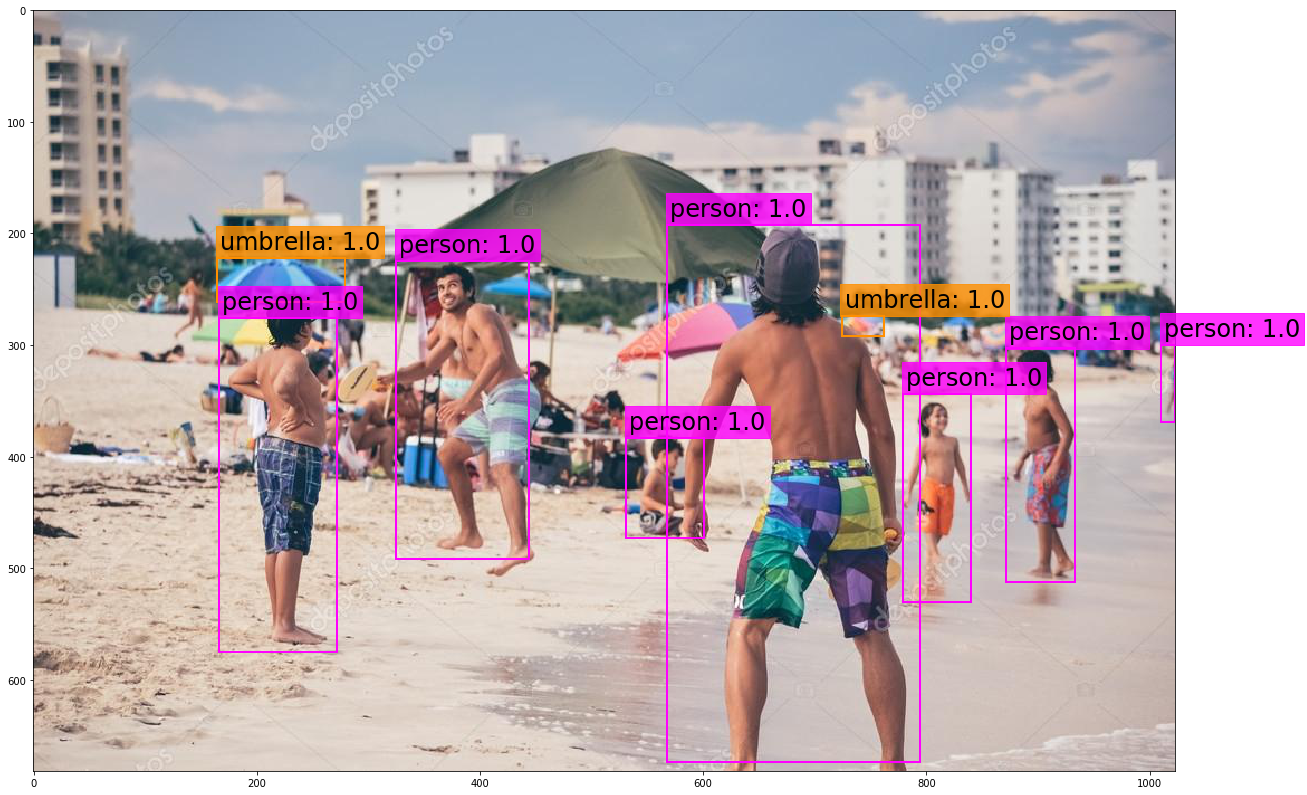

In [15]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]

img = cv2.imread('./images/beachpeople.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

iou_thresh = 0.4
nms_thresh = 0.6

boxes = detect_objects(model, img, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
# NOTE: I'am running it on an Intel inside CPU
print_objects(boxes, class_names)

# Plot the image with bounding boxes and corresponding object class labels
plot_boxes(img, boxes, class_names, plot_labels=True)